<center>
    <p style="text-align:center">
        <h1>OpenLLM</h1>
        <img alt="BentoML logo" src="https://raw.githubusercontent.com/bentoml/BentoML/main/docs/source/_static/img/bentoml-logo-black.png" width="200"/>
        </br>
        <a href="https://github.com/bentoml/OpenLLM">GitHub</a>
        |
        <a href="https://l.bentoml.com/join-openllm-discord">Community</a>
    </p>
</center>
<h1 align="center">Serving Llama2 with OpenLLM</h1>

[OpenLLM](https://github.com/bentoml/OpenLLM) is an open-source framework for serving and operating any Large Language Models (LLMs) in production.

This is a project demonstrating basic usage of OpenLLM with
Llama 2 as an example. In this tutorial, you will learn the following:

- Set up your environment to work with OpenLLM.
- Use OpenLLM Python APIs to create a demo.
- Serve LLMs like Llama 2 with just a single command.
- Explore different ways to interact with the OpenLLM server.
- Build bentos for production deployment.

## Set up the environment

You can try this demo in one of the following ways:

1. Via Google Colab.

   We recommend you run this demo on a GPU. To verify if you're using a GPU on Google Colab, check the runtime type in the top left corner.

   To change the runtime type: In the toolbar menu, click **Runtime** > **Change runtime type** > Select the GPU (T4)
   
   Paid users may have access to more advanced GPUs (e.g, A100). For free users, the T4 GPU might occasionally be unavailable.

2. (Optional) Run this project locally.

    If you have a GPU, you can also run this notebook locally with:
    
    ```
    git clone git@github.com:bentoml/OpenLLM.git && cd OpenLLM/examples/openllm-llama2-demo && jupyter notebook
    ```

### [Optional] Check GPU and memory resources

In [ ]:
##@title Check the memory and GPU info you have
import psutil
import torch


ram = psutil.virtual_memory()
ram_total = ram.total / (1024**3)
print('MemTotal: %.2f GB' % ram_total)

print('=============GPU INFO=============')
if torch.cuda.is_available():
  !/opt/bin/nvidia-smi || ture
else:
  print('GPU NOT available')

### Install required dependencies

In [ ]:
!pip install -U -q  openllm[llama,vllm] openai langchain
!apt install tensorrt

## Python API demo

You can create a simple demo of serving LLMs quickly by using Openllm runner.
Learn more about Runners in the [BentoML documentation](https://docs.bentoml.com/en/latest/concepts/runner.html).

Firstly, let's initialize an OpenLLM Runner locally.
- Here, we're serving the smallest Llama 2 model, the 7 billion parameter version. You can simply change 7b in the string with 13b or 70b for the larger parameter sizes. but a larger model means larger VRAM.
- we recommend you use vLLM as the backend for better performance.
- we set `torch_dtype` as `float16` manaually to avoid such in-compatible error that may have when loading `Bfloat16` on T4 or V100 GPUs. You do not have to do this if you are runing on more more advanced GPUs.
  ```
  ValueError: Bfloat16 is only supported on GPUs with compute capability of at least 8.0. Your Tesla T4 GPU has compute capability 7.5.
  ```

In [ ]:
import openllm


llm = openllm.LLM('NousResearch/Nous-Hermes-llama-2-7b', backend='vllm', torch_dtype='float16', embedded=True)

### Test it with an prompt  

In [ ]:
import asyncio

import nest_asyncio


nest_asyncio.apply()


async def main():
  async for gen in llm.generate_iterator('What is the weather like in San Francisco?', max_new_tokens=128):
    print(gen.outputs[0].text, flush=True, end='')


asyncio.run(main())

### Clean up


In [ ]:
import gc
import torch

del llm

torch.cuda.empty_cache()
gc.collect()

## OpenLLM server demo

### Launch an OpenLLM server

it is quite straightforward to Launch an OpenLLM server. With just a single command
```
openllm start {MODEL_ID} --backend [pt|vllm|...]
```

OpenLLM supports a variety of LLMs and archtiectures. Learn more in https://github.com/bentoml/OpenLLM#-supported-models.

To unblock the following steps, run it in the background via `nohup`:

In [4]:
!nohup openllm start NousResearch/Nous-Hermes-llama-2-7b --port 8001 --dtype float16 --backend vllm > openllm.log 2>&1 &

### [IMPORTANT] Server status check

Before you interact with the OpenLLM server, it's crucial to ensure that it is up and running. The output of the `curl` command should start with `HTTP/1.1 200 OK`, meaning everything is in order.

If it says `curl: (7) Failed to connect to localhost...`, then check `./openllm.log`; likely the server has failed to start or is still in the process of starting.

If it says `HTTP/1.1 503 Service Unavailable`, the server is still starting and you should wait a bit and retry.

In [ ]:
! curl -i http://127.0.0.1:8001/readyz

### Interact with the LLM server

Use one of the following ways to access the server.

1. Run the `openllm query` command to query the model:



In [ ]:
!openllm query --endpoint http://127.0.0.1:8001 --timeout 120 "What is the weight of the earth?"

2. if you are in Google Colab, visit the web UI.

In [ ]:
import sys


if 'google.colab' in sys.modules:
  # using colab proxy URL
  from google.colab.output import eval_js

  print('you are in colab runtime. please try it out in %s' % eval_js('google.colab.kernel.proxyPort(8001)'))

3. Use OpenLLM's built-in Python client.

In [ ]:
import openllm


# sync API
client = openllm.HTTPClient('http://127.0.0.1:8001', timeout=120)
res = client.generate('What is the weight of the earth?', max_new_tokens=8192)

# Async API
# async_client = openllm.AsyncHTTPClient("http://127.0.0.1:8001", timeout=120)
# res = await async_client.generate("what is the weight of the earth?", max_new_tokens=8192)
print(res.outputs[0].text)

In [ ]:
# streaming
for it in client.generate_stream('What is the weight of the earth?', max_new_tokens=2048, n=2, best_of=2):
  #print(f'index {it.index}: {it.text} (token: {it.token_ids})')
  print(it.text, end="")

4. Send a request using `curl`.

In [ ]:
!curl -k -X 'POST' -N \
  'http://127.0.0.1:8001/v1/generate_stream' \
  -H 'accept: text/event-stream' \
  -H 'Content-Type: application/json' \
  -d '{"prompt":"write a tagline for an ice cream shop", "llm_config": {"max_new_tokens": 256}}'

5. Use the OpenAI compatible endpoint.

In [ ]:
import openai
import os


client = openai.OpenAI(base_url=os.getenv('OPENLLM_ENDPOINT', 'http://localhost:8001') + '/v1', api_key='na')
models = client.models.list()
print('Models:', models.model_dump_json(indent=2))
model = models.data[0].id

#os.environ["STREAM"] = "TRUE"
stream = str(os.getenv('STREAM', False)).upper() in ['TRUE', '1', 'YES', 'Y', 'ON']

completions = client.completions.create(
  prompt='Write me a tag line for an ice cream shop.', model=model, max_tokens=64, stream=stream
)

print(f'Completion result (stream={stream}):')
if stream:
  for chunk in completions:
    text = chunk.choices[0].text
    if text:
      print(text, flush=True, end='')
else:
  print(completions.choices[0].text)

#### LangChain integration

OpenLLM supports integration with LangChain. You can use `langchain.llms.OpenLLM` to interact with the remote OpenLLM server. You can connect to it by specifying its URL:


In [10]:
from langchain.llms import OpenLLM


llm = OpenLLM(server_url='http://localhost:8001')

In [ ]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate


template = 'What is a good name for a company that makes {product}?'

prompt = PromptTemplate(template=template, input_variables=['product'])

llm_chain = LLMChain(prompt=prompt, llm=llm)

generated = llm_chain.run(product='mechanical keyboard')
print(generated)

### Stop the server in the background

In [34]:
!pkill -f 'bentoml|openllm'

## Deploy Llama2 in production with BentoCloud

After you test the server, you can deploy it in production using BentoCloud.

### What is BentoCloud?

[BentoCloud](https://www.bentoml.com/cloud) is a fully-managed platform designed for building and operating AI applications.

  * Easiest way to deploy and operate AI applications.
  * Natively support the OpenLLM workflow and optimization.

If you don't have a BentoCloud account, visit the [BentoCloud website](https://www.bentoml.com/cloud) to start a free trial.


You can follow the steps in these blog posts to deploy your LLM to BentoCloud:

* [llama2-7b](https://www.bentoml.com/blog/deploying-llama-2-7b-on-bentocloud)
* [llama2-13b](https://www.bentoml.com/blog/openllm-in-action-part-2-deploying-llama-2-13b-on-bentocloud)
* [llama2-70b]()

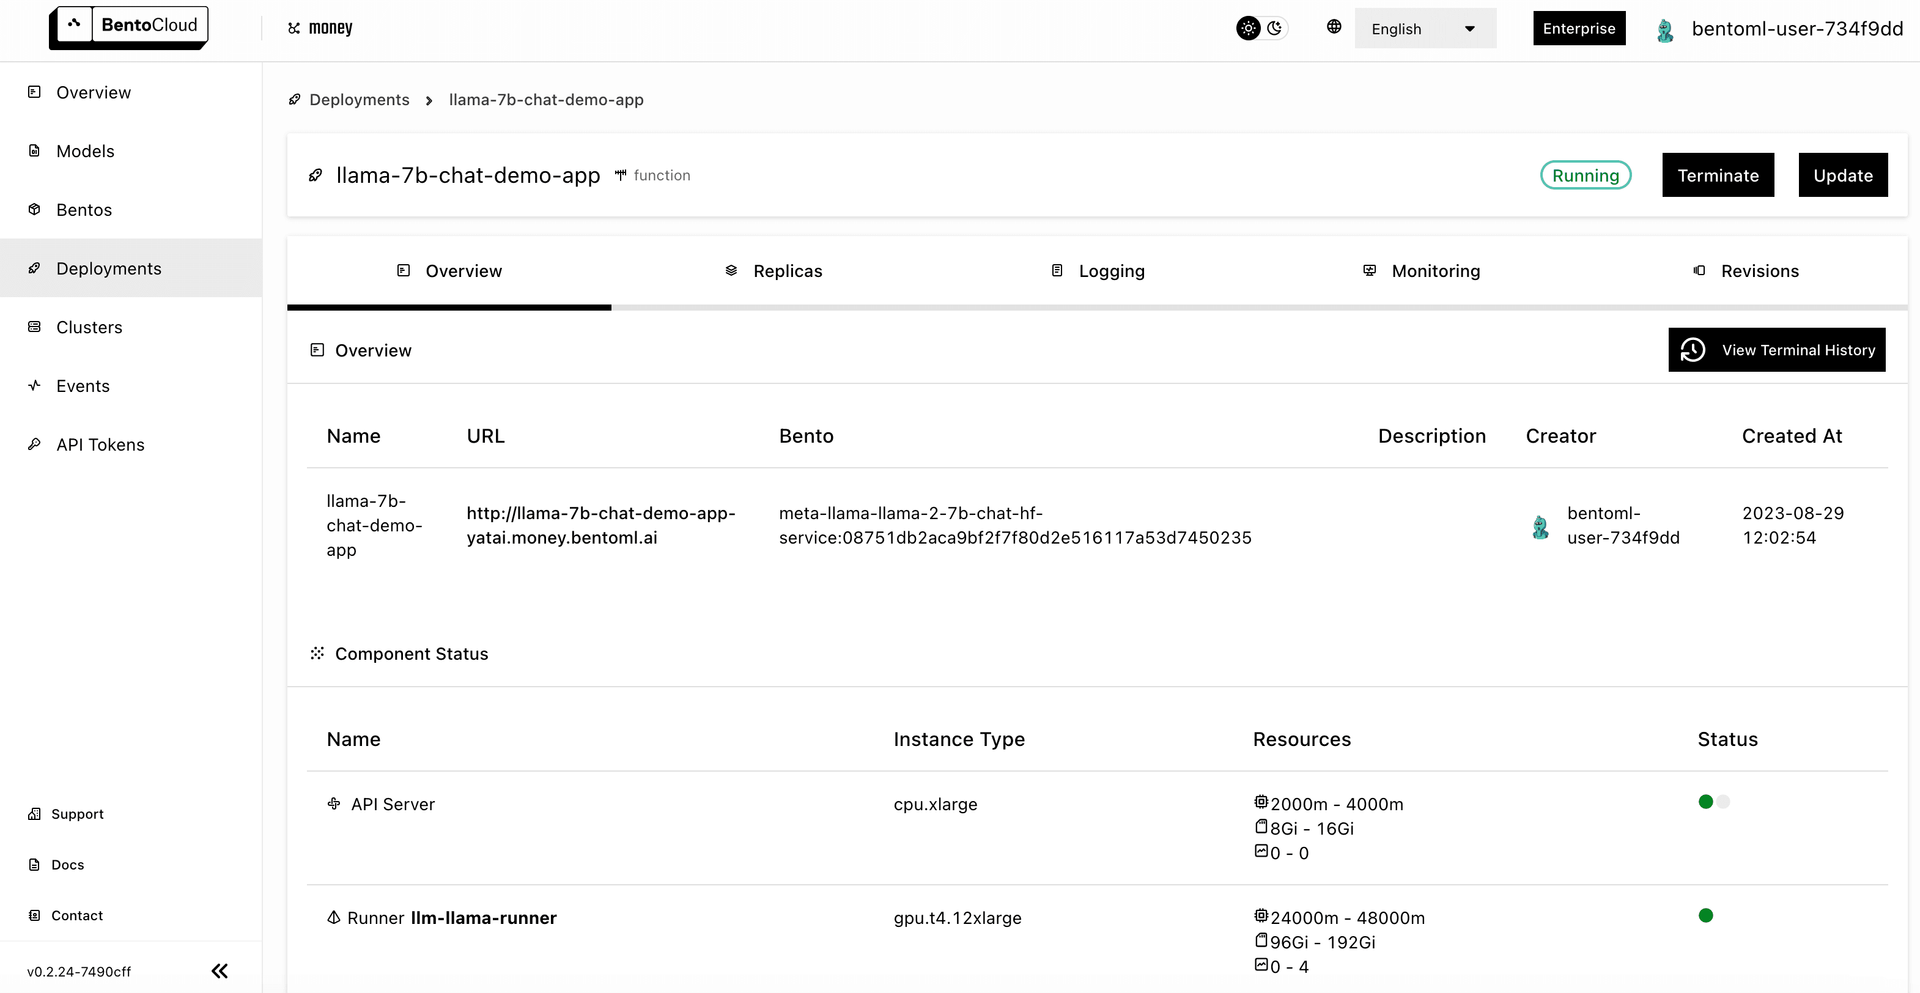

### Build a Bento

Use OpenLLM to build the model into a standardized distribution unit in BentoML, also known as a Bento. Command:

```
openllm build {model-id} --backend [pt|vllm]
```

In [ ]:
!openllm build NousResearch/Nous-Hermes-llama-2-7b --backend vllm --dtype float16

### View the Bento

In [ ]:
!openllm list-bentos

### Log in to BentoCloud and push the Bento

To log in to BentoCloud and push the Bento to it, you need your BentoCloud endpoint URL and an API token. For more information, see [Manage access tokens](https://docs.bentoml.com/en/latest/bentocloud/how-tos/manage-access-token.html).

In [ ]:
return_code = !bentoml cloud list-context

if 'colab-user' not in ''.join(return_code):
  # Log in to BentoCloud
  endpoint = input('input endpoint (like https://xxx.cloud.bentoml.com): ')
  token = input('input token (please follow https://docs.bentoml.com/en/latest/bentocloud/how-tos/manage-access-token.html#creating-an-api-token):')
  !bentoml cloud login --api-token {token} --endpoint {endpoint} --context colab-user

# Replace the Bento tag with your own
!bentoml push nousresearch--nous-hermes-llama-2-7b-service:b7c3ec54b754175e006ef75696a2ba3802697078 --context colab-user

### Create a Deployment via the BentoCloud Console

Follow this [guide](https://www.bentoml.com/blog/deploying-llama-2-7b-on-bentocloud) to deploy this Bento on BentoCloud.

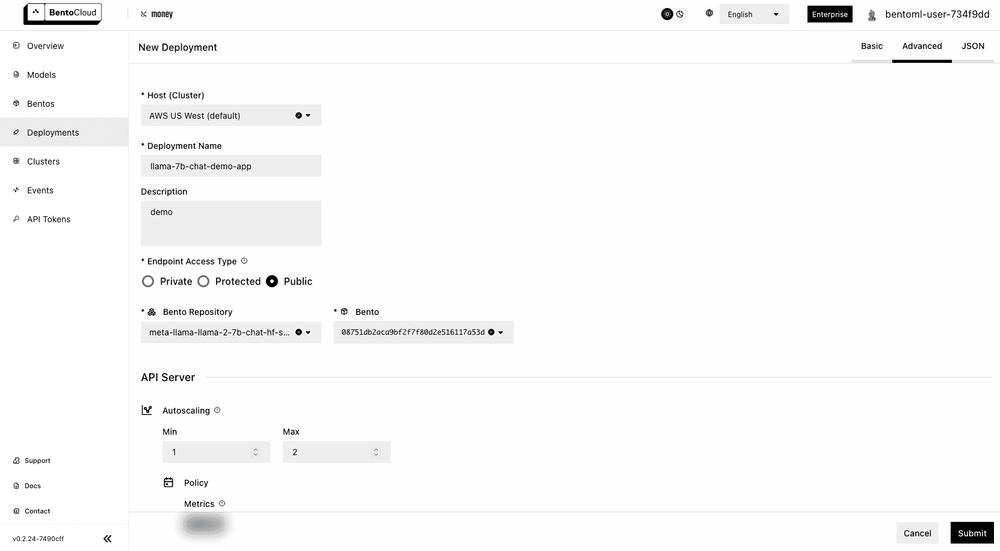

### Create a Deployment via the BentoML client

You can find detailed configuration in [Deployment creation and update information](https://docs.bentoml.com/en/latest/bentocloud/reference/deployment-creation-and-update-info.html).

📢 Make sure you have logged in to BentoCloud in the last step.

In [ ]:
###@title Alternatively, use the BentoML client to create a Deployment.
import json

import bentoml


return_code = !bentoml cloud list-context
if 'colab-user' not in ''.join(return_code):
  print('please login first!')
else:
  client = bentoml.cloud.BentoCloudClient()
  # runner config
  runner = bentoml.cloud.Resource.for_runner(
    resource_instance='starter-aws-g4dn-xlarge-gpu-t4-xlarge'
    # hpa_conf={"min_replicas": 1, "max_replicas": 1},
  )
  # api-server hpa config
  api_server = bentoml.cloud.Resource.for_api_server(resource_instance='starter-aws-t3-2xlarge-cpu-small')
  hpa_conf = bentoml.cloud.Resource.for_hpa_conf(min_replicas=1, max_replicas=1)

  res = client.deployment.create(
    deployment_name='test-llama2',
    bento='nousresearch--nous-hermes-llama-2-7b-service:b7c3ec54b754175e006ef75696a2ba3802697078',
    context='colab-user',
    cluster_name='default',
    # mode="deployment",
    kube_namespace='yatai',
    runners_config={'llm-llama-runner': runner},
    api_server_config=api_server,
    hpa_conf=hpa_conf,
  )
  print(json.dump(res, indent=4))